<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#参考情報" data-toc-modified-id="参考情報-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>参考情報</a></span></li><li><span><a href="#迷路" data-toc-modified-id="迷路-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>迷路</a></span></li><li><span><a href="#Q学習" data-toc-modified-id="Q学習-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Q学習</a></span></li><li><span><a href="#インポート" data-toc-modified-id="インポート-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>インポート</a></span></li><li><span><a href="#クラス定義" data-toc-modified-id="クラス定義-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>クラス定義</a></span><ul class="toc-item"><li><span><a href="#環境" data-toc-modified-id="環境-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>環境</a></span></li><li><span><a href="#エージェント" data-toc-modified-id="エージェント-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>エージェント</a></span></li></ul></li><li><span><a href="#シミュレーション" data-toc-modified-id="シミュレーション-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>シミュレーション</a></span></li></ul></div>

# 参考情報


# 迷路
<img src="Meiro.png", width=500>

# Q学習
<img src="Q_Learning.png", width=500>

オレンジのパスがQ値を最大にするパスである場合、
$$\begin{eqnarray}
Q(s_0,b) &=& r_2 + \gamma Q(s_2,a)  \\
         &=& r_2 + \gamma r_5 + \gamma^2 Q(s_5,a) \\
         &=& r_2 + \gamma r_5 + \gamma^2 r_9
\end{eqnarray}$$

アルファ碁解体新書(p.140)によれば
<img src="QLearning_Fig.png", width=500>

# インポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython import display

# クラス定義

## 環境

In [2]:
class Enviro:
    def __init__(self):
        self.state = {}
        self.state[0] = [ 0, 1, 4, 0]
        self.state[1] = [ 1, 2, 1, 0]
        self.state[2] = [ 2, 3, 2, 1]
        self.state[3] = [ 3, 3, 7, 2]
        self.state[4] = [ 0, 5, 8, 4]
        self.state[5] = [ 5, 6, 9, 4]
        self.state[6] = [ 6, 6, 10, 5]
        self.state[7] = [ 3, 7, 11, 7]
        self.state[8] = [ 4, 8, 8, 8]
        self.state[9] = [ 5, 9, 13, 9]
        self.state[10] = [ 6, 10, 14, 10]
        self.state[11] = [ 7, 11, 11, 11]
        self.state[12] = [ 12, 13, 12, 12]
        self.state[13] = [ 9, 13, 13, 12]
        self.state[14] = [ 10, 15, 14, 14]
        self.state[15] = [ 15, 16, 15, 14]

    def move(self, current_state, action ):
        next_state = self.state[current_state][action]
        if next_state == 16:
            reward = 1.0
        else:
            reward = 0
        return next_state, reward

    def get_goal(self):
        return 16


In [3]:
%qtconsole

## エージェント

In [4]:
class Agent:
    def __init__(self):
        self.qt = np.zeros( [17, 4] )
        self.visit = np.ones( [17, 4] )
        self.eps = 0.4
        self.gamma = 0.9
        self.alp = 0.01

    def action(self, state):
        ngame = np.sum( self.visit[15][1] )
        if np.random.rand() < self.eps * 1.386 / np.log(ngame):
            act = int( np.random.rand() * 4 )
        else:
            act = np.argmax( self.qt[state] )
        return act

    def action_ucb1(self, state):
        total_visit = np.sum( self.visit[state] )
        total_rewards = np.sum( self.qt[state] ) + 1e-10
#        ucb1 = self.qt[state] / total_rewards + \
#               np.sqrt( 2.0 * np.log(total_visit / self.visit[state] ) )

        ucb1 = self.qt[state] + \
               np.sqrt( ( 2.0 * np.log(total_visit )  ) / self.visit[state] )

#        print( state, total_visit, total_rewards, ucb1 )
        act = np.argmax( ucb1 )
        return act

    def update( self, src, act, dst, reward ):
        maxq = np.max( self.qt[dst])
        td_diff = reward + self.gamma * maxq - self.qt[src,act]
        self.qt[src,act] += self.alp * td_diff
        self.visit[src,act] += 1

    def get_qt(self):
        return self.qt

    def get_visit(self):
        return self.visit


# シミュレーション

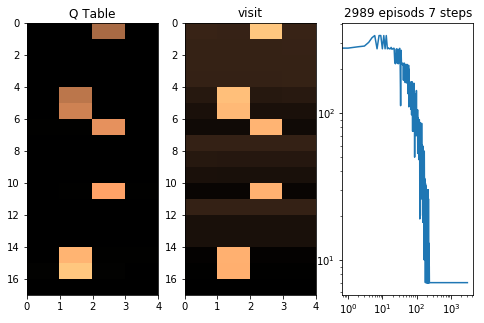

In [8]:
ev = Enviro()
ag = Agent()

goal = ev.get_goal()

%matplotlib inline
fig, ax = plt.subplots( 1,3, figsize=[8,5])
plt.show()

nepi = 3000
cnts = np.zeros( [nepi,1])
cntacc = 0
for epi in range(nepi):
    state = 0
    cnt = 0
    while state < goal:
        act = ag.action_ucb1(state)
#        act = ag.action(state)
        new_state, reward = ev.move(state,act)
        ag.update( state, act, new_state, reward )
        state = new_state
        cnt += 1
    cnts[epi] = cnt
    cntacc += cnt
    if cntacc > 100:
        cntacc = 0
        ax[0].clear()
        ax[0].pcolor( ag.get_qt(), cmap='copper' )
        ax[0].invert_yaxis()
        ax[0].set_title( "Q Table" )

        ax[1].clear()
        ax[1].pcolor( ag.get_visit(), cmap='copper' )
        ax[1].invert_yaxis()
        ax[1].set_title( "visit" )

        ax[2].clear()
        ax[2].loglog( cnts[:epi] )
        ax[2].set_title( "%d episods %d steps" % (epi,cnt))

        display.clear_output(wait=True)
        display.display(fig)
